### Initialize dependencies

In [18]:
import sys
sys.path.append('../../')
import helper

import numpy as np

### Method source code

In [19]:
from helper.package_dataset.module_mse import *
import numdifftools as nd
import math


# ====================================================<< Adam with custom gradient func >>====================================================== #

def train_definition_adam(
    f,
    x_train,
    y_train,
    eps_minimum,
    x0,
    batch_size=None,
    lr_scheduling_func=constant_lr_scheduling,
    initial_lr=1.0,
    num_iterations=10000,
    grad_method='default',
    apply_min=True,
    apply_value=True,
    eps_Adam=1e-8,
    f_torch=None
):
    B1 = 0.9
    B2 = 0.99

    x = np.copy(x0)
    points = [x.copy()]
    value = 0.0
    G = eps_Adam
    moment = 0.0

    grad_lambda = nd.Gradient(lambda w: mse_loss(f, w, x_train, y_train))

    grad_vectors_torch = []
    grad_vectors_definition = []
    grad_vectors_nd = []

    x_train_torch, y_train_torch = torch.from_numpy(x_train), torch.from_numpy(y_train)

    if batch_size is None:
        batch_size = len(x_train)

    if apply_value:
        value = mse_loss(f, x, x_train, y_train)

    for i in range(1, num_iterations):
        if apply_value:
            if apply_min and value < eps_minimum:
                break
        else:
            if apply_min and mse_loss(f, x, x_train, y_train) < eps_minimum:
                break

        # Torch gradient
        torch_w = torch.tensor(x, requires_grad=True)

        if f_torch is not None:
            value = helper.mse_loss_torch(x_train_torch, y_train_torch, torch_w, f_torch)
        else:
            value = helper.mse_loss_torch(x_train_torch, y_train_torch, torch_w, f)

        value.backward()
        grad_vectors_torch.append(torch_w.grad)

        # numdifftools gradient
        grad_nd = grad_lambda(x)
        grad_vectors_nd.append(grad_nd)
        
        # Definition gradient
        grad_x = mse_loss_grad(f, x, x_train, y_train, batch_size)
        grad_vectors_definition.append(grad_x)

        if grad_method == 'torch':
            grad_x = np.array(torch_w.grad.tolist())
        elif grad_method == 'numdifftools':
            grad_x = grad_nd

        moment = moment * B1 + (1 - B1) * grad_x
        G = G*B2 + (1 - B2) * (grad_x.dot(grad_x))

        moment_more = moment / (1 - B1 ** i)
        G_more = G / (1 - B2 ** i)
        new_x = x - lr_scheduling_func(i, initial_lr) * moment_more / (math.sqrt(G_more + eps_Adam))

        if apply_value:
            new_value = mse_loss(f, new_x, x_train, y_train)
            if new_value < value:
                x = new_x
                value = new_value
        else:
            x = new_x

        points.append(x.copy())

    return points, grad_vectors_torch, grad_vectors_definition, grad_vectors_nd

# ====================================================<< Adam >>====================================================== #

## $(1 - x \cdot w[0])^2 + 100 \cdot (x \cdot w[1] - x^2)^2$

### Dataset initializing

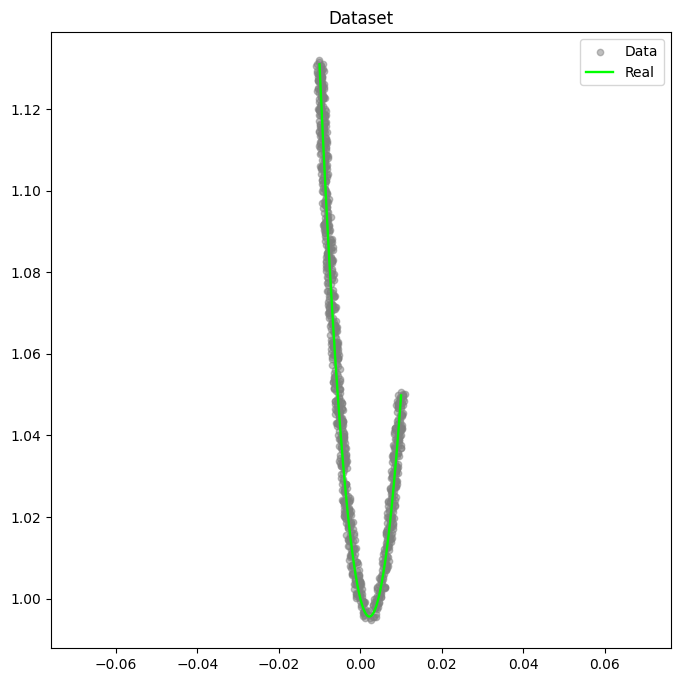

In [20]:
import torch


dataset_name = '1'
dataset_params = helper.get_params_dataset(dataset_name)
dataset_filename = helper.get_filenames_datasets()[dataset_name]
f = helper.get_func_research(dataset_params['f_label'])

X, Y, datasets = helper.load_datasets(dataset_filename)

helper.print_generated(X, Y, datasets[0], title="Dataset")

real_w = np.array([dataset_params["w0"], dataset_params["w1"]], dtype=float)

x_train_numpy, y_train_numpy = datasets[0][:, :-1], datasets[0][:, -1:]

eps_minimum = helper.mse_loss(f, real_w, x_train_numpy, y_train_numpy)
eps_minimum = eps_minimum*1.1

initial_w = np.array([-1.0, 0.1])

### Steps research

In [21]:
grad_methods = ['torch', 'default', 'numdifftools']


for grad_method in grad_methods:
    points, _, _, _ = train_definition_adam(f, x_train_numpy, y_train_numpy, eps_minimum, initial_w, initial_lr=0.5, grad_method=grad_method)
    print(f'steps using {grad_method} grad: {len(points)}')

steps using torch grad: 53
steps using default grad: 53
steps using numdifftools grad: 53


In [22]:
points, grad_vectors_torch, grad_vectors_definition, grad_vectors_nd = train_definition_adam(f, x_train_numpy, y_train_numpy, eps_minimum, initial_w, initial_lr=0.5)

print('points:')
print(*points, sep='\n')

print('Torch grad:')
for grad in grad_vectors_torch:
    print('%8.20f   %8.20f' % (grad.tolist()[0], grad.tolist()[1]))
    # print(*(grad.tolist()))

print('Definition grad:')
for grad in grad_vectors_definition:
    print('%8.20f   %8.20f' % (grad[0], grad[1]))

print('numdifftool:')
for grad in grad_vectors_nd:
    print('%8.20f   %8.20f' % (grad[0], grad[1]))

points:
[-1.   0.1]
[-0.57678877  0.1428186 ]
[-0.1277511   0.19970195]
[0.32609547 0.27259823]
[0.77590872 0.36496325]
[1.21492731 0.48099727]
[1.63642527 0.62526415]
[2.03325739 0.80210572]
[2.39818918 1.01475914]
[2.72482372 1.26434027]
[3.00872559 1.54906308]
[3.24801955 1.86391292]
[3.44288032 2.20032239]
[3.59395403 2.54460721]
[3.59395403 2.54460721]
[3.59395403 2.54460721]
[3.62536682 2.84952583]
[3.62536682 2.84952583]
[3.62536682 2.84952583]
[3.62536682 2.84952583]
[3.62536682 2.84952583]
[3.50360499 2.97842798]
[3.36054734 3.06634659]
[3.20067996 3.10689489]
[3.02874328 3.10196932]
[2.84917807 3.06034101]
[2.66621807 2.99490932]
[2.4842399  2.92014154]
[2.3078744  2.84996596]
[2.3078744  2.84996596]
[2.3078744  2.84996596]
[2.15932261 2.82475716]
[2.15932261 2.82475716]
[2.03297561 2.83515893]
[1.91913551 2.86229071]
[1.81895847 2.90343464]
[1.73292482 2.95384031]
[1.73292482 2.95384031]
[1.73292482 2.95384031]
[1.73292482 2.95384031]
[1.73292482 2.95384031]
[1.70685825 3.01

## $\sin{(x \cdot (w[o])^2)} + \cos{(x \cdot (w[1])^2)}$

### Dataset initializing

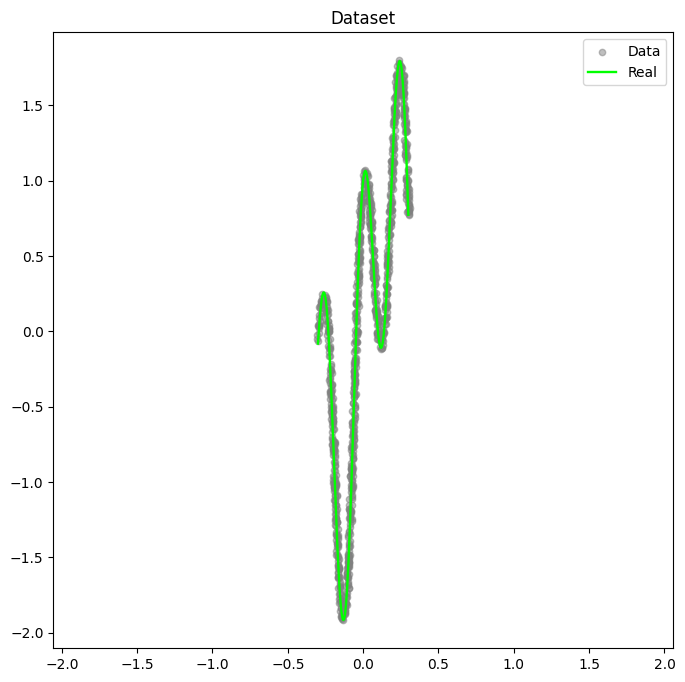

In [23]:
import torch


dataset_name = '2'
dataset_params = helper.get_params_dataset(dataset_name)
dataset_filename = helper.get_filenames_datasets()[dataset_name]
f = helper.get_func_research(dataset_params['f_label'])

X, Y, datasets = helper.load_datasets(dataset_filename)

helper.print_generated(X, Y, datasets[0], title="Dataset")

real_w = np.array([dataset_params["w0"], dataset_params["w1"]], dtype=float)

x_train_numpy, y_train_numpy = datasets[0][:, :-1], datasets[0][:, -1:]

eps_minimum = helper.mse_loss(f, real_w, x_train_numpy, y_train_numpy)
eps_minimum = eps_minimum*1.1

initial_w = np.array([-1.0, 0.1])

### Steps research

In [26]:
grad_methods = ['default', 'torch', 'numdifftools']

def f_torch(x, w):
    return torch.sin(x * w[0] ** 2) + torch.cos(x * w[1] ** 2)

for grad_method in grad_methods:
    points, _, _, _ = train_definition_adam(f, x_train_numpy, y_train_numpy, eps_minimum, initial_w, initial_lr=0.5, grad_method=grad_method, f_torch=f_torch)
    print(f'steps using {grad_method} grad: {len(points)}')

steps using default grad: 10000
steps using torch grad: 10000
steps using numdifftools grad: 10000


In [28]:
points, grad_vectors_torch, grad_vectors_definition, grad_vectors_nd = train_definition_adam(f, x_train_numpy, y_train_numpy, eps_minimum, initial_w, initial_lr=0.5, f_torch=f_torch)

print('points:')
print(*points, sep='\n')

print('Torch grad:')
for grad in grad_vectors_torch:
    print('%8.20f   %8.20f' % (grad.tolist()[0], grad.tolist()[1]))
    # print(*(grad.tolist()))

print('Definition grad:')
for grad in grad_vectors_definition:
    print('%8.20f   %8.20f' % (grad[0], grad[1]))

print('numdifftool:')
for grad in grad_vectors_nd:
    print('%8.20f   %8.20f' % (grad[0], grad[1]))

points:
[-1.   0.1]
[-1.49999814  0.10010405]
[-1.99913464  0.10021469]
[-2.48186913  0.10034282]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10048417]
[-2.95399593  0.10